[![Open In nbviewer](https://img.shields.io/badge/Jupyter-nbviewer-orange?logo=jupyter)](
https://nbviewer.org/github/RadyaSRN/road-objects-detection/blob/main/notebooks/road_objects_detection.ipynb)
[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](
https://www.kaggle.com/kernels/welcome?src=https://github.com/RadyaSRN/road-objects-detection/blob/main/notebooks/road_objects_detection.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/RadyaSRN/road-objects-detection/blob/main/notebooks/road_objects_detection.ipynb)
[![W&B Report](https://img.shields.io/badge/Weights%20&%20Biases-Report-orange?logo=weightsandbiases)](
https://wandb.ai/radyasrn-mipt/CV-spring-2025/reports/CV-spring-2025-road-objects-detection--VmlldzoxNDIxMDgxMg)

<b><font size=5>**Introduction**</font></b>

The notebook is divided into two parts, each of which is divided into steps:

- [Part 1: Training Detection Models](#part-1-training-detection-models)
  - [Step 1.1: Exploratory Data Analysis](#step-11-exploratory-data-analysis)
  - [Step 1.2: Model Training](#step-12-model-training)
- [Part 2: Applying Model to Real World Video](#part-2-applying-model-to-real-world-video)
  - [Step 2.1: Splitting Video into Frames](#step-21-splitting-video-into-frames)
  - [Step 2.2: Applying Model to Frames](#step-22-applying-model-to-frames)
  - [Step 2.3: Combining Frames into Final Video](#step-23-combining-frames-into-final-video)

This notebook presents a pipeline for training **RetinaNet** and **SSD** detection models (part $1$) to apply them to **real world traffic video from Moscow** (part $2$).

The project was carried out in a Kaggle environment with a P100 GPU.

Let's make the necessary imports:

In [ ]:
!pip install pytorch_lightning

In [3]:
# Standard library utilities
import os
import time
from collections import defaultdict
from functools import lru_cache
from glob import glob

# Libraries for data analysis
import numpy as np
import pandas as pd

# Libraries for image processing
import albumentations as A
import cv2
import networkx as nx
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
from PIL import Image
from scipy.ndimage import convolve
from scipy.spatial import KDTree
from shapely.geometry import LineString
from shapely.ops import linemerge
from skimage.morphology import skeletonize
from sklearn.cluster import DBSCAN
from skimage.measure import label, regionprops

# Libraries for visualization
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sns.set()

# Libraries for learning
import pytorch_lightning as pl
import torch
import torch.optim as optim
import torchmetrics
import torchvision
import wandb
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.classification import JaccardIndex, BinaryJaccardIndex
from torchvision import models
from tqdm.notebook import tqdm

# Libraries for networking and authorization
import gdown
import requests
from io import BytesIO
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

# Models, dataset and utils
from src.models import RetinaNetLightningModel, SSDLightningModel
from src.dataset import ObjectionDetectionDataset
from src.utils import iou, write_frames_with_masks, combine_frames_into_video

---
<a name="part-1-training-detection-models"></a>
# <b><font size=5>**Part $1$:**</font></b>

In this part, we will examine the used dataset and train detection models.

<a name="step-11-exploratory-data-analysis"></a>
<b><font size=3>**Step $1.1$:**</font></b>

In this step, we perform exploratory data analysis on our selected dataset.

We will use [Traffic Road Object Detection Polish 12k](https://www.kaggle.com/datasets/mikoajkoek/traffic-road-object-detection-polish-12k), which contains 11$ classes that are quite common on roads. Let's download it:

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mikoajkoek/traffic-road-object-detection-polish-12k")

print("Path to dataset files:", path)

Let's take a look at the image files:

In [ ]:
!ls /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection/train/images | head -10

Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.0cf604913d4b57b9350c575fa4a1694a_aug_out_0.png
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.0cf604913d4b57b9350c575fa4a1694a_aug_out_1.png
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.0cf604913d4b57b9350c575fa4a1694a.jpg
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.3066702898a6628a5a3adf2f526f758e_aug_out_0.png
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.3066702898a6628a5a3adf2f526f758e_aug_out_1.png
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.3066702898a6628a5a3adf2f526f758e.jpg
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.78649a8cfa8157ccba636aa2be0ed028_aug_out_0.png
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.78649a8cfa8157ccba636aa2be0ed028_aug_out_1.png
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.78649a8cfa8157ccba636aa2be0ed028.jpg
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0004_jpg.rf.102c148201a90564d1a7adcff5df92f7_aug_out_0.png
ls: write error: Broken pipe


Let's take a look at the mask files:

In [ ]:
!ls /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection/train/labels | head -10

Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.0cf604913d4b57b9350c575fa4a1694a_aug_out_0.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.0cf604913d4b57b9350c575fa4a1694a_aug_out_1.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.0cf604913d4b57b9350c575fa4a1694a.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.3066702898a6628a5a3adf2f526f758e_aug_out_0.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.3066702898a6628a5a3adf2f526f758e_aug_out_1.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.3066702898a6628a5a3adf2f526f758e.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.78649a8cfa8157ccba636aa2be0ed028_aug_out_0.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.78649a8cfa8157ccba636aa2be0ed028_aug_out_1.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.78649a8cfa8157ccba636aa2be0ed028.txt
Film100-Wykonano-za-pomoca-Clipchamp_mp4-0004_jpg.rf.102c148201a90564d1a7adcff5df92f7_aug_out_0.txt
ls: write error: Broken pipe


Let's take a look at one of the mask files inside:

In [ ]:
!cat /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection/train/labels/Film100-Wykonano-za-pomoca-Clipchamp_mp4-0000_jpg.rf.0cf604913d4b57b9350c575fa4a1694a_aug_out_0.txt

0  0.03551081081081084  0.7060230547550432  0.07102162162162168  0.08468299711815563
0  0.08961081081081086  0.6889048991354467  0.06420540540540551  0.054048991354466835
0  0.1399675675675676  0.6866426512968299  0.05407567567567566  0.053155619596541914
0  0.220054054054054  0.6897982708933718  0.0493405405405406  0.04864553314121034
0  0.3075891891891892  0.6722334293948127  0.04460540540540542  0.06216138328530274
0  0.44682162162162153  0.7456484149855906  0.20817297297297288  0.22521613832853016
8  0.6403027027027027  0.5043371757925071  0.05665945945945916  0.06886167146974054
6  0.6455783783783784  0.5683861671469741  0.04943783783783784  0.06367435158501444
1  0.600854054054054  0.5831844380403458  0.051113513513513675  0.050345821325648465
1  0.5566918918918918  0.6331700288184438  0.022778378378378594  0.030360230547550326


Let's look at the list of classes and information about them:

In [ ]:
dataset_data_df = pd.read_csv(f'{path}/data.csv')
dataset_data_df

,Set,Photos,Car,Different-Traffic-Sign,Red-Traffic-Light,Pedestrian,Warning-Sign,Pedestrian-Crossing,Green-Traffic-Light,Prohibition-Sign,Truck,Speed-Limit-Sign,Motorcycle
0,Test Set,166,687,547,163,137,79,82,52,48,66,22,4
1,Train Set,1178,4766,3370,805,812,544,476,402,396,409,230,38
2,Validation Set,327,1343,945,232,228,163,112,87,112,137,59,10
3,Test Set (Augmented),996,4122,3282,978,822,474,492,312,288,396,132,24
4,Train Set (Augmented),7068,28596,20220,4830,4872,3264,2856,2412,2376,2454,1380,228
5,Validation Set (Augmented),1962,8058,5670,1392,1368,978,672,522,672,822,354,60


We can see that there is no underrepresentation of classes, except perhaps for motorcycles. For simplicity, we will not use all classes in this project; we will combine certain classes together. Therefore, based on what we have seen, we will make two mappings: `CLASS_NAMES` in `/src/dataset.py` and `CLASS_MAPPING` in `/src/utils.py`:

```python
CLASS_NAMES = {
  0: 'Car',
  1: 'Pedestrian',
  2: 'Motorcycle',
  3: 'Traffic-Sign',
  4: 'Traffic-Light'
}

CLASS_MAPPING = {
  0: 0,  # Car
  1: 3,  # Different-Traffic-Sign
  2: 4,  # Red-Traffic-Light
  3: 1,  # Pedestrian
  4: 3,  # Warning-Sign
  6: 4,  # Green-Traffic-Light
  7: 3,  # Prohibition-Sign
  8: 0,  # Truck
  9: 3,  # Speed-Limit-Sign
  10: 2  # Motorcycle
}
```

<a name="step-12-model-training"></a>
<b><font size=3>**Step $1.2$:**</font></b>

In this step, we will train RetinaNet, as this model is notable for producing few false positives and recognizing small objects well (meaning that in the real world, we can know about an approaching car well in advance).

We will set the transformations from Albumentations. We will not make the transformations too drastic, because photos from the camera are still taken under normal conditions in a standard horizontal orientation. We will also add normalization for the backbone of our model in the form of `ResNet-50-FPN`. After that, we will define the loaders:

In [ ]:
train_transforms_detection = A.Compose([
  A.LongestMaxSize(1024),
  A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, value=0),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(p=0.3),
  A.RandomGamma(p=0.3),
  A.CLAHE(p=0.2),
  A.GaussianBlur(blur_limit=(3, 5), p=0.2),
  A.ShiftScaleRotate(p=0.3),
  A.Normalize(mean=(0.485, 0.456, 0.406),
              std=(0.229, 0.224, 0.225)),
  ToTensorV2(),
], bbox_params=A.BboxParams(
  format='pascal_voc',
  label_fields=['labels'],
  min_visibility=0.0,
  check_each_transform=False,
  clip=True
))

val_transforms_detection = A.Compose([
  A.LongestMaxSize(1024),
  A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, value=0),
  A.Normalize(mean=(0.485, 0.456, 0.406),
              std=(0.229, 0.224, 0.225)),
  ToTensorV2(),
], bbox_params=A.BboxParams(
  format='pascal_voc',
  label_fields=['labels'],
  min_visibility=0.0,
  check_each_transform=False,
  clip=True
))

full_dataset_path = f'{path}/road_detection/road_detection'

train_dataset_detection = ObjectionDetectionDataset(f'{full_dataset_path}/train/images', f'{full_dataset_path}/train/labels', train_transforms_detection)
val_dataset_detection = ObjectionDetectionDataset(f'{full_dataset_path}/valid/images', f'{full_dataset_path}/valid/labels', val_transforms_detection)

batch_size_detection = 12

num_workers = max(os.cpu_count() - 2, 1)

train_loader_detection = torch.utils.data.DataLoader(
    train_dataset_detection,
    batch_size=batch_size_detection,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers,
    pin_memory=True
)
val_loader_detection = torch.utils.data.DataLoader(
    val_dataset_detection,
    batch_size=batch_size_detection,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers,
    pin_memory=True
)

Let's log in to wandb:

In [ ]:
wandb.login(key='', relogin=True)
wandb.finish()

We will track Mean Average Precision, or more precisely map50, as this is a classic metric for detection tasks. We will train RetinaNet for $4$ epochs with `lr=1e-4, weight_decay=1e-2`:

In [ ]:
wandb.init(project='CV-spring-2025', name='retinanet-run-17')

checkpoint_callback_retinanet = pl.callbacks.ModelCheckpoint(
  monitor='val_map_50',
  mode='max',
  dirpath='checkpoints/',
  filename='best-retinanet',
  save_top_k=1,
  save_last=True
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
trainer_retinanet = pl.Trainer(
  accelerator='gpu',
  precision='32-true',
  max_epochs=4,
  callbacks=[checkpoint_callback_retinanet, TQDMProgressBar(refresh_rate=10)],
  logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

retinanet_model = RetinaNetLightningModel(lr=1e-4, weight_decay=1e-2)

trainer_retinanet.fit(retinanet_model, train_loader_detection, val_loader_detection)

Then we will finish the run:

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████████
train_loss,█▇▆▆▄▅▄▅▄▄▃▄▃▃▄▄▂▄▂▃▂▃▂▂▂▂▃▂▁▃▃▂▂▂▂▁▂▂▁▂
train_map_50,▁▅▇█
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_loss,█▃▃▁
val_map_50,▁▆▆█
epoch,3
train_loss,0.37271
train_map_50,0.64181
trainer/global_step,3491
val_loss,0.47335


It seems that a little more training could be done to improve quality. Let's train it on `lr=1e-5, weight_decay=1e-2` for $1$ epoch:

In [ ]:
wandb.init(project='CV-spring-2025', name='retinanet-run-19')

ckpt_path = 'checkpoints/best-retinanet.ckpt'
retinanet_model = RetinaNetLightningModel.load_from_checkpoint(
    ckpt_path,
    lr=1e-5,
    weight_decay=1e-2
)

checkpoint_callback_retinanet = pl.callbacks.ModelCheckpoint(
  monitor='val_map_50',
  mode='max',
  dirpath='checkpoints/',
  filename='best-retinanet',
  save_top_k=1,
  save_last=True
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
trainer_retinanet = pl.Trainer(
  accelerator='gpu',
  precision='32-true',
  max_epochs=1,
  callbacks=[checkpoint_callback_retinanet, TQDMProgressBar(refresh_rate=10)],
  logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

trainer_retinanet.fit(retinanet_model, train_loader_detection, val_loader_detection)

Then we finish the run:

In [ ]:
wandb.finish()

Let's look at the training history:

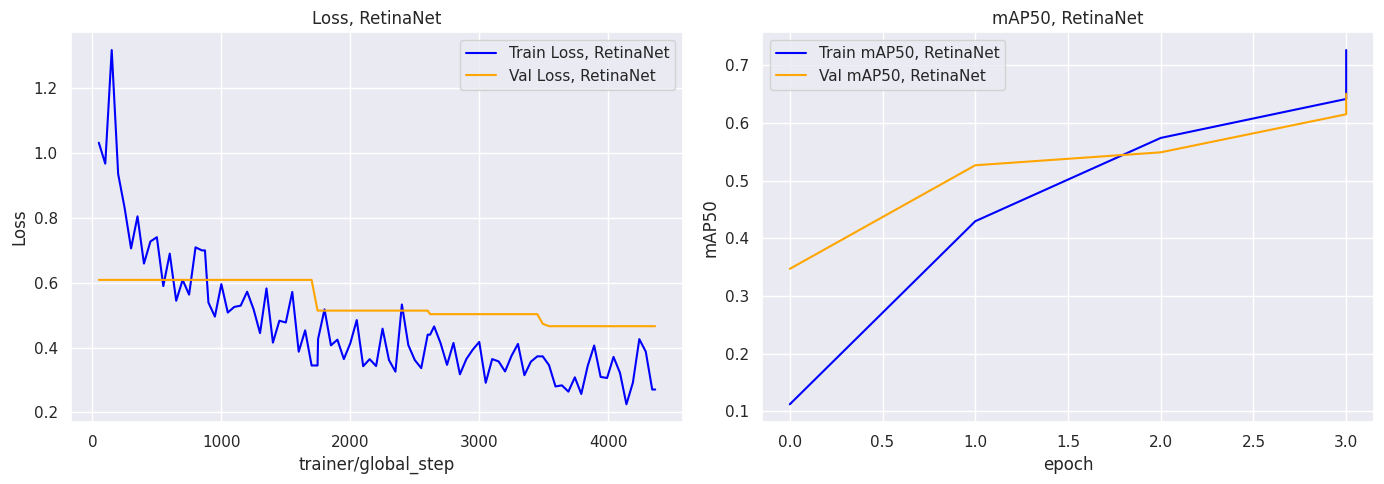

In [5]:
api = wandb.Api()

run_retinanet_first = api.run('radyasrn-mipt/CV-spring-2025/3udv7srb')
run_retinanet_second = api.run('radyasrn-mipt/CV-spring-2025/shj9ufft')

history_retinanet_first = run_retinanet_first.history()
history_retinanet_second = run_retinanet_second.history()

history_retinanet_first_val_map_50 = history_retinanet_first[~history_retinanet_first['val_map_50'].isna()][['epoch', 'val_map_50']].set_index('epoch')
history_retinanet_first_train_map_50 = history_retinanet_first[~history_retinanet_first['train_map_50'].isna()][['epoch', 'train_map_50']].set_index('epoch')

history_retinanet_first = history_retinanet_first.fillna(method='ffill')
history_retinanet_first = history_retinanet_first.fillna(method='bfill')

history_retinanet_first_val_loss = history_retinanet_first[['trainer/global_step', 'val_loss']].set_index('trainer/global_step')
history_retinanet_first_train_loss = history_retinanet_first[['trainer/global_step', 'train_loss']].set_index('trainer/global_step')

history_retinanet_second_val_map_50 = history_retinanet_second[~history_retinanet_second['val_map_50'].isna()][['epoch', 'val_map_50']].set_index('epoch')
history_retinanet_second_val_map_50.index += history_retinanet_first_val_map_50.index[-1]
history_retinanet_second_train_map_50 = history_retinanet_second[~history_retinanet_second['train_map_50'].isna()][['epoch', 'train_map_50']].set_index('epoch')
history_retinanet_second_train_map_50.index += history_retinanet_first_train_map_50.index[-1]

history_retinanet_second = history_retinanet_second.fillna(method='ffill')
history_retinanet_second = history_retinanet_second.fillna(method='bfill')

history_retinanet_second_val_loss = history_retinanet_second[['trainer/global_step', 'val_loss']].set_index('trainer/global_step')
history_retinanet_second_val_loss.index += history_retinanet_first_val_loss.index[-1]
history_retinanet_second_train_loss = history_retinanet_second[['trainer/global_step', 'train_loss']].set_index('trainer/global_step')
history_retinanet_second_train_loss.index += history_retinanet_first_train_loss.index[-1]

retinanet_val_map_50 = pd.concat([history_retinanet_first_val_map_50, history_retinanet_second_val_map_50])
retinanet_train_map_50 = pd.concat([history_retinanet_first_train_map_50, history_retinanet_second_train_map_50])
retinanet_val_loss = pd.concat([history_retinanet_first_val_loss, history_retinanet_second_val_loss])
retinanet_train_loss = pd.concat([history_retinanet_first_train_loss, history_retinanet_second_train_loss])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(retinanet_train_loss, color='blue', label='Train Loss, RetinaNet')
axs[0].plot(retinanet_val_loss, color='orange', label='Val Loss, RetinaNet')
axs[0].set_xlabel('trainer/global_step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss, RetinaNet')
axs[0].legend()

axs[1].plot(retinanet_train_map_50, color='blue', label='Train mAP50, RetinaNet')
axs[1].plot(retinanet_val_map_50, color='orange', label='Val mAP50, RetinaNet')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('mAP50')
axs[1].set_title('mAP50, RetinaNet')
axs[1].legend()

plt.tight_layout()
plt.show()

Now let's train the SSD. Some of its advantages are its size and inference speed. Let's set a slightly different normalization required for the backbone in the form of `VGG16`. After that, we will define the loaders:

In [ ]:
train_transforms_detection_ssd = A.Compose([
  A.LongestMaxSize(1024),
  A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, value=0),
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(p=0.3),
  A.RandomGamma(p=0.3),
  A.CLAHE(p=0.2),
  A.GaussianBlur(blur_limit=(3, 5), p=0.2),
  A.ShiftScaleRotate(p=0.3),
  A.Normalize(mean=(0.48235, 0.45882, 0.40784),
              std=(0.00392156862745098, 0.00392156862745098, 0.00392156862745098)),
  ToTensorV2(),
], bbox_params=A.BboxParams(
  format='pascal_voc',
  label_fields=['labels'],
  min_visibility=0.0,
  check_each_transform=False,
  clip=True
))

val_transforms_detection_ssd = A.Compose([
  A.LongestMaxSize(1024),
  A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, value=0),
  A.Normalize(mean=(0.48235, 0.45882, 0.40784),
              std=(0.00392156862745098, 0.00392156862745098, 0.00392156862745098)),
  ToTensorV2(),
], bbox_params=A.BboxParams(
  format='pascal_voc',
  label_fields=['labels'],
  min_visibility=0.0,
  check_each_transform=False,
  clip=True
))

train_dataset_detection_ssd = ObjectionDetectionDataset(f'{full_dataset_path}/train/images', f'{full_dataset_path}/train/labels', train_transforms_detection_ssd)
val_dataset_detection_ssd = ObjectionDetectionDataset(f'{full_dataset_path}/valid/images', f'{full_dataset_path}/valid/labels', val_transforms_detection_ssd)

train_loader_detection_ssd = torch.utils.data.DataLoader(
    train_dataset_detection_ssd,
    batch_size=batch_size_detection,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers,
    pin_memory=True
)
val_loader_detection_ssd = torch.utils.data.DataLoader(
    val_dataset_detection_ssd,
    batch_size=batch_size_detection,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers,
    pin_memory=True
)

We will train it so that the time is approximately the same as when training RetinaNet (since the models are almost identical in size). We will train it for $10$ epochs with `lr=1e-4, weight_decay=1e-2`:

In [ ]:
wandb.init(project='CV-spring-2025', name='ssd-run-1')

checkpoint_callback_ssd = pl.callbacks.ModelCheckpoint(
  monitor='val_map_50',
  mode='max',
  dirpath='checkpoints/',
  filename='best-ssd',
  save_top_k=1,
  save_last=True
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
trainer_ssd = pl.Trainer(
  accelerator='gpu',
  precision='32-true',
  max_epochs=10,
  callbacks=[checkpoint_callback_ssd, TQDMProgressBar(refresh_rate=10)],
  logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

ssd_model = SSDLightningModel(lr=1e-4, weight_decay=1e-2)

trainer_ssd.fit(ssd_model, train_loader_detection_ssd, val_loader_detection_ssd)

Then we will finish the run:

In [ ]:
wandb.finish()

We will additionally train the model for $6$ epochs at `lr=1e-5, weight_decay=1e-2`, so that the training of this model takes approximately the same amount of time as RetinaNet:

In [ ]:
wandb.init(project='CV-spring-2025', name='ssd-run-3')

ckpt_path = 'checkpoints/best-ssd.ckpt'
ssd_model = SSDLightningModel.load_from_checkpoint(
    ckpt_path,
    lr=1e-5,
    weight_decay=1e-2
)

checkpoint_callback_ssd = pl.callbacks.ModelCheckpoint(
  monitor='val_map_50',
  mode='max',
  dirpath='checkpoints/',
  filename='best-ssd',
  save_top_k=1,
  save_last=True
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
trainer_ssd = pl.Trainer(
  accelerator='gpu',
  precision='32-true',
  max_epochs=6,
  callbacks=[checkpoint_callback_ssd, TQDMProgressBar(refresh_rate=10)],
  logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

trainer_ssd.fit(ssd_model, train_loader_detection_ssd, val_loader_detection_ssd)

Then we will finish the run:

In [ ]:
wandb.finish()

Let's look at the training results for each model:

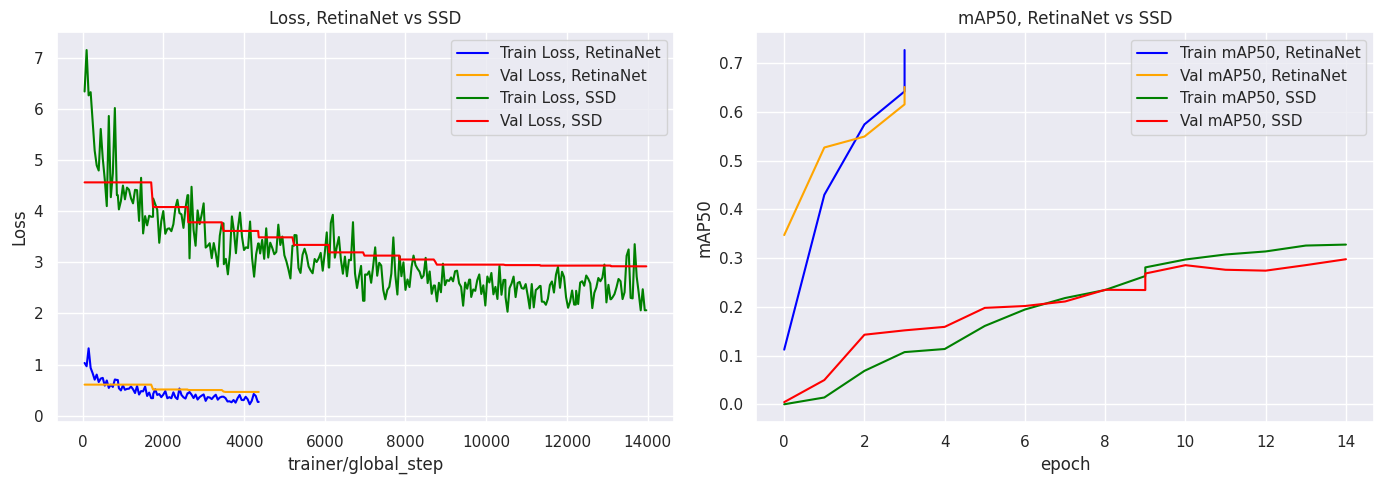

In [6]:
run_ssd_first = api.run('radyasrn-mipt/CV-spring-2025/r2gzuxud')
run_ssd_second = api.run('radyasrn-mipt/CV-spring-2025/b8bhprsn')

history_ssd_first = run_ssd_first.history()
history_ssd_second = run_ssd_second.history()

history_ssd_first_val_map_50 = history_ssd_first[~history_ssd_first['val_map_50'].isna()][['epoch', 'val_map_50']].set_index('epoch')
history_ssd_first_train_map_50 = history_ssd_first[~history_ssd_first['train_map_50'].isna()][['epoch', 'train_map_50']].set_index('epoch')

history_ssd_first = history_ssd_first.fillna(method='ffill')
history_ssd_first = history_ssd_first.fillna(method='bfill')

history_ssd_first_val_loss = history_ssd_first[['trainer/global_step', 'val_loss']].set_index('trainer/global_step')
history_ssd_first_train_loss = history_ssd_first[['trainer/global_step', 'train_loss']].set_index('trainer/global_step')

history_ssd_second_val_map_50 = history_ssd_second[~history_ssd_second['val_map_50'].isna()][['epoch', 'val_map_50']].set_index('epoch')
history_ssd_second_val_map_50.index += history_ssd_first_val_map_50.index[-1]
history_ssd_second_train_map_50 = history_ssd_second[~history_ssd_second['train_map_50'].isna()][['epoch', 'train_map_50']].set_index('epoch')
history_ssd_second_train_map_50.index += history_ssd_first_train_map_50.index[-1]

history_ssd_second = history_ssd_second.fillna(method='ffill')
history_ssd_second = history_ssd_second.fillna(method='bfill')

history_ssd_second_val_loss = history_ssd_second[['trainer/global_step', 'val_loss']].set_index('trainer/global_step')
history_ssd_second_val_loss.index += history_ssd_first_val_loss.index[-1]
history_ssd_second_train_loss = history_ssd_second[['trainer/global_step', 'train_loss']].set_index('trainer/global_step')
history_ssd_second_train_loss.index += history_ssd_first_train_loss.index[-1]

ssd_val_map_50 = pd.concat([history_ssd_first_val_map_50, history_ssd_second_val_map_50])
ssd_train_map_50 = pd.concat([history_ssd_first_train_map_50, history_ssd_second_train_map_50])
ssd_val_loss = pd.concat([history_ssd_first_val_loss, history_ssd_second_val_loss])
ssd_train_loss = pd.concat([history_ssd_first_train_loss, history_ssd_second_train_loss])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(retinanet_train_loss, color='blue', label='Train Loss, RetinaNet')
axs[0].plot(retinanet_val_loss, color='orange', label='Val Loss, RetinaNet')
axs[0].plot(ssd_train_loss, color='green', label='Train Loss, SSD')
axs[0].plot(ssd_val_loss, color='red', label='Val Loss, SSD')
axs[0].set_xlabel('trainer/global_step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss, RetinaNet vs SSD')
axs[0].legend()

axs[1].plot(retinanet_train_map_50, color='blue', label='Train mAP50, RetinaNet')
axs[1].plot(retinanet_val_map_50, color='orange', label='Val mAP50, RetinaNet')
axs[1].plot(ssd_train_map_50, color='green', label='Train mAP50, SSD')
axs[1].plot(ssd_val_map_50, color='red', label='Val mAP50, SSD')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('mAP50')
axs[1].set_title('mAP50, RetinaNet vs SSD')
axs[1].legend()

plt.tight_layout()
plt.show()

We can see that in this project, the RetinaNet model is significantly better than SSD, even though they are roughly the same size and were trained for approximately the same amount of time. For this reason, we will use RetinaNet in the next section.


---
<a name="part-2-applying-model-to-real-world-video"></a>
# <b><font size=5>**Part $2$:**</font></b>

In this part, we will apply SSD to detect road objects in real world traffic video from Moscow.

<a name="step-21-splitting-video-into-frames"></a>
<b><font size=3>**Step $2.1$:**</font></b>

In this step, we will split the video into individual frames.

We will be using the following [video](https://www.youtube.com/watch?v=adrZBv0kQyg), recorded in Moscow. We install a command line tool for downloading videos from YouTube:

In [ ]:
!pip install -U yt-dlp

Let's take a look at the available download formats:

In [ ]:
!yt-dlp -F "https://www.youtube.com/watch?v=adrZBv0kQyg"

[youtube] Extracting URL: https://www.youtube.com/watch?v=adrZBv0kQyg
[youtube] adrZBv0kQyg: Downloading webpage
[youtube] adrZBv0kQyg: Downloading tv client config
[youtube] adrZBv0kQyg: Downloading player 73381ccc-main
[youtube] adrZBv0kQyg: Downloading tv player API JSON
[youtube] adrZBv0kQyg: Downloading ios player API JSON
[youtube] adrZBv0kQyg: Downloading m3u8 information
[info] Available formats for adrZBv0kQyg:
ID      EXT   RESOLUTION FPS CH │   FILESIZE    TBR PROTO │ VCODEC           VBR ACODEC      ABR ASR MORE INFO
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
sb2     mhtml 48x27        0    │                   mhtml │ images                                   storyboard
sb1     mhtml 80x45        0    │                   mhtml │ images                                   storyboard
sb0     mhtml 160x90       0    │                   mhtml │ images                                   storyboard


Let's load the format `299` - `1920x1080`, `60fps`. We will load the segment from `00:01:33` to `00:02:03`:

In [ ]:
!yt-dlp -f 299 --download-sections *00:01:33-00:02:03 -o road_video.mp4 https://www.youtube.com/watch\?v\=adrZBv0kQyg

Let's set the frame rate to `30fps` so that the boxes are smoother:

In [ ]:
!ffmpeg -i road_video.mp4 -an -c:v libx264 -preset fast -crf 23 -r 30 -y road_video_30fps.mp4

Let's break the video down into individual frames:

In [ ]:
video_path = 'road_video_30fps.mp4'
input_dir = 'frames_raw'
os.makedirs(input_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_idx = 0

while True:
  success, frame = cap.read()
  if not success:
    break
  frame_path = os.path.join(input_dir, f'frame_{frame_idx:05d}.jpg')
  cv2.imwrite(frame_path, frame)
  frame_idx += 1

cap.release()

<a name="step-22-applying-model-to-frames"></a>
<b><font size=3>**Step $2.2$:**</font></b>

In this step, we will apply our SSD model to each frame.

Let's load the model:

In [ ]:
device = 'cuda'
ckpt_path = 'checkpoints/best-retinanet-v1.ckpt'
retinanet_model = RetinaNetLightningModel.load_from_checkpoint(
    ckpt_path,
    lr=1e-5,
    weight_decay=1e-2
)
retinanet_model = retinanet_model.to(device).eval()

We will use a function to convert the source frames into frames with prediction boxes. We will need to stabilize the boxes because they may “jitter” due to prediction errors between neighboring frames. To do this, we will apply exponential smoothing to the detection boxes. It works as follows:

* Predict the boxes for the new frame
* For each of the boxes, we look for a box from the past with $IoU > 0.5$. We consider this to be the same object in the past
* We mark the box from the past as used
* We exponentially smooth the boxes and scores

Now let's apply this function:

In [ ]:
write_frames_with_masks(
     input_dir,
     output_dir='frames_smoothed',
     model=retinanet_model,
     do_ewm_smoothing=True
)

write_frames_with_masks(
     input_dir,
     output_dir='frames_unsmoothed',
     model=retinanet_model,
     do_ewm_smoothing=False
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<a name="step-23-combining-frames-into-final-video"></a>
<b><font size=3>**Step $2.3$:**</font></b>

In this step, we will use a function to compile a video from frames with boxes.

Let's apply this function with and without exponential smoothing:

In [ ]:
combine_frames_into_video(output_dir='frames_smoothed', video_name='road_video_30_fps_with_objects_smoothed')
combine_frames_into_video(output_dir='frames_unsmoothed', video_name='road_video_30_fps_with_objects_unsmoothed')

  0%|          | 0/902 [00:00<?, ?it/s]

  0%|          | 0/902 [00:00<?, ?it/s]

Videos are available at [this link](https://drive.google.com/drive/folders/1DQuDF65cL2-g32aFht-sqq54833jYKMc?usp=sharing)

![road-objects-detection-20fps](../images/road-objects-detection-20fps.gif)